In [3]:
from research.utils.data_access_utils import RDSAccessUtils
import os
import json
import pandas as pd

rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [33]:
from datetime import date
from dateutil.relativedelta import relativedelta

three_months_ago = date.today() + relativedelta(months=-3)
start_date = three_months_ago.strftime('%Y-%m-%d')
today = (date.today()).strftime('%Y-%m-%d')

'2021-03-15'

In [10]:
query = '''
    SELECT service_id, pen_id, annotation_state_id, left_crop_url, left_crop_metadata, right_crop_url,
    right_crop_metadata, camera_metadata, captured_at, skip_reasons, annotation FROM prod.crop_annotation
    WHERE pen_id IN (56, 60, 37, 85, 86, 66, 83, 84, 95, 100, 61, 1, 4, 126, 128, 129, 133, 122, 123,
    137, 114, 119, 116, 131, 132, 5, 145, 171, 173, 138, 149, 159, 210, 211, 67, 193, 140, 142, 216)
    AND captured_at >= '%s'
    AND annotation_state_id IN (3, 4, 7) AND (service_id=1)
''' % (start_date, )

annotations = rds_access_utils.extract_from_database(query)

In [11]:
annotations = annotations[(annotations['left_crop_url'].notnull()) | (annotations['right_crop_url'].notnull())]

annotations['time_bucket'] = annotations['captured_at'].apply(lambda c: c.hour // 2)
annotations['is_qa_accept'] = annotations['annotation_state_id'] == 7

accepts = annotations[annotations['is_qa_accept']]

accepts['visibleBodySections'] = accepts['annotation'].apply(
    lambda ann: ann['visibleBodySections'] if 'visibleBodySections' in ann else None)

accepts['isPartial'] = accepts['annotation'].apply(
    lambda ann: ann['isPartial'] if 'isPartial' in ann else None)

accepts = accepts[~(accepts['isPartial'] & accepts['visibleBodySections'].isnull())]
len(accepts)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


193955

### confident cogito skips and confident QA accepts, just be to sure the labels have clear differences.

In [12]:
bodyparts = list(accepts['visibleBodySections'].explode().unique())

for part in bodyparts:
    if part is not None:
        accepts['HAS_' + part] = accepts['visibleBodySections'].apply(
            lambda sections: part in sections if sections is not None else True)
        print(part, accepts['HAS_' + part].value_counts(normalize=True).loc[True])

DORSAL_ANTERIOR 0.7689515609290815
HEAD 0.5552370395194761
VENTRAL_ANTERIOR 0.8397205537366915
DORSAL_POSTERIOR 0.4571678997705653
VENTRAL_POSTERIOR 0.48385965816813176


In [13]:
SAMPLES_PER_PEN = 5000
SAMPLE_SIZE = SAMPLES_PER_PEN // len(annotations['time_bucket'].unique())
print(SAMPLE_SIZE)

def sample_from_pen(pen_rows, sample_strat='random', sample_size=SAMPLE_SIZE):
    if sample_strat == 'random':
        return pen_rows.sample(min(len(pen_rows), int(sample_size)))
    elif sample_strat == 'recent':
        sorted_rows = pen_rows.sort_values(['is_qa_accept', 'captured_at'], ascending=False)
        sorted_rows.drop_duplicates(subset='left_crop_url', inplace=True)
        sorted_rows.drop_duplicates(subset='right_crop_url', inplace=True)
        return sorted_rows.head(sample_size)
    else:
        assert False

416


In [14]:
accepts = annotations[annotations['annotation_state_id'].isin([7])]
accepts = accepts.groupby(['pen_id', 'time_bucket'], group_keys=False).apply(sample_from_pen)
len(accepts)

61936

In [15]:
bucket_sample_sizes = accepts[['pen_id', 'time_bucket']].apply(lambda row: tuple(row), axis=1).value_counts()
bucket_sample_sizes

(123, 6)     416
(86, 0)      416
(86, 9)      416
(67, 1)      416
(193, 5)     416
            ... 
(123, 10)      1
(216, 8)       1
(4, 8)         1
(4, 11)        1
(173, 8)       1
Length: 181, dtype: int64

In [16]:
def sample_equal_skips_to_accepts(pen_rows):
    sample_size = pen_rows.sample_size.unique()
    assert len(sample_size) == 1
    sample_size = sample_size[0]
    return sample_from_pen(pen_rows, sample_size=sample_size)

In [17]:
from tqdm import tqdm
tqdm.pandas()

cogito_skips = annotations[annotations['annotation_state_id'] == 4]
cogito_skips.drop_duplicates('left_crop_url', inplace=True)
cogito_skips.drop_duplicates('right_crop_url', inplace=True)
def get_sample_size(row):
    try:
        return bucket_sample_sizes[(row['pen_id'], row['time_bucket'])]
    except:
        return 0
cogito_skips['sample_size'] = cogito_skips.progress_apply(get_sample_size , axis=1)
chosen_cogito_skips = cogito_skips.groupby(['pen_id', 'time_bucket'], group_keys=False).apply(sample_equal_skips_to_accepts)
len(chosen_cogito_skips)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 41693/41693 [00:08<00:00, 4752.16it/s]
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

21535

In [18]:
still_need = accepts.pen_id.value_counts() - chosen_cogito_skips.pen_id.value_counts()
print(still_need.sum() + len(chosen_cogito_skips))
still_need

61936


1       400
4      1803
5      1242
67     2965
85     3300
86     3082
116    4698
119    1666
122      91
123       1
138    3661
140     581
142     611
145    1321
149    3137
159    1900
171     418
173    2003
193    4446
210    1228
211    1364
216     483
Name: pen_id, dtype: int64

In [19]:
leftover_skips = cogito_skips[~cogito_skips['left_crop_url'].isin(chosen_cogito_skips['left_crop_url'])]
leftover_skips = leftover_skips[~cogito_skips['right_crop_url'].isin(chosen_cogito_skips['right_crop_url'])]

leftover_skips['sample_size'] = leftover_skips['pen_id'].progress_apply(
    lambda p: still_need[p])
chosen_cogito_skips2 = leftover_skips.groupby(['pen_id'], group_keys=False).apply(sample_equal_skips_to_accepts)
chosen_cogito_skips = pd.concat([chosen_cogito_skips, chosen_cogito_skips2])
len(chosen_cogito_skips)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
100%|██████████| 20158/20158 [00:00<00:00, 64761.29it/s]


25577

In [20]:
still_need = accepts.time_bucket.value_counts() - chosen_cogito_skips.time_bucket.value_counts()
extras = still_need[still_need<0].sum() * -1
still_need = still_need[still_need>0]
still_need = ((still_need / still_need.sum()) * extras).apply(int)
still_need

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
Name: time_bucket, dtype: int64

In [21]:
leftover_skips = cogito_skips[~cogito_skips['left_crop_url'].isin(chosen_cogito_skips['left_crop_url'])]
leftover_skips = leftover_skips[~cogito_skips['right_crop_url'].isin(chosen_cogito_skips['right_crop_url'])]

leftover_skips['sample_size'] = leftover_skips['time_bucket'].progress_apply(
    lambda p: 0 if p not in still_need else still_need[p])
chosen_cogito_skips2 = leftover_skips.groupby(['time_bucket'], group_keys=False).apply(sample_equal_skips_to_accepts)
chosen_cogito_skips = pd.concat([chosen_cogito_skips, chosen_cogito_skips2])
len(chosen_cogito_skips)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
100%|██████████| 16116/16116 [00:00<00:00, 58361.66it/s]


25577

In [22]:
skip_dataset = pd.concat([chosen_cogito_skips, accepts.sample(len(chosen_cogito_skips))])
skip_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51154 entries, 70119 to 251225
Data columns (total 14 columns):
annotation             25577 non-null object
annotation_state_id    51154 non-null int64
camera_metadata        51154 non-null object
captured_at            51154 non-null datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]
is_qa_accept           51154 non-null bool
left_crop_metadata     43171 non-null object
left_crop_url          43171 non-null object
pen_id                 51154 non-null int64
right_crop_metadata    43517 non-null object
right_crop_url         43517 non-null object
sample_size            25577 non-null float64
service_id             51154 non-null int64
skip_reasons           51154 non-null object
time_bucket            51154 non-null int64
dtypes: bool(1), datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)](1), float64(1), int64(4), object(7)
memory usage: 5.5+ MB


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [23]:
skip_dataset['is_qa_accept'].value_counts()

True     25577
False    25577
Name: is_qa_accept, dtype: int64

In [24]:
def get_label(state_id):
    if state_id == 4:
        return 'SKIP'
    elif state_id in [3,7]:
        return 'ACCEPT'
    else:
        assert False

skip_dataset['label'] = skip_dataset['annotation_state_id'].apply(get_label)
skip_dataset['label'].value_counts()

ACCEPT    25577
SKIP      25577
Name: label, dtype: int64

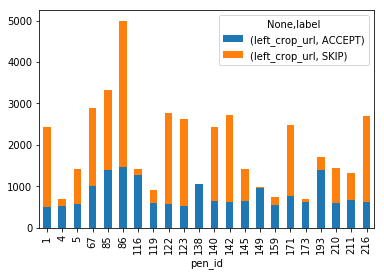

In [25]:
pd.DataFrame(skip_dataset.groupby(['pen_id', 'label'])['left_crop_url'].aggregate('count')).unstack().plot(kind='bar', stacked=True)

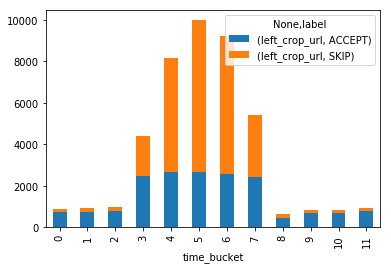

In [26]:
pd.DataFrame(skip_dataset.groupby(['time_bucket', 'label'])['left_crop_url'].aggregate('count')).unstack().plot(kind='bar', stacked=True)

In [27]:
skip_dataset[skip_dataset['right_crop_metadata'].isnull()]['right_crop_metadata']

249088    None
286257    None
200706    None
386666    None
164544    None
          ... 
101844    None
10280     None
214838    None
486905    None
316421    None
Name: right_crop_metadata, Length: 7637, dtype: object

In [28]:
def get_url(row):
    if row['left_crop_url'] is None:
        return row['right_crop_url']
    if row['right_crop_url'] is None:
        return row['left_crop_url']
    else:
        if row['left_crop_metadata']['quality_score'] > row['left_crop_metadata']['quality_score']:
            return row['left_crop_url']
        else:
            return row['right_crop_url']
        
skip_dataset['url'] = skip_dataset.apply(get_url, axis=1)

In [29]:
len(skip_dataset['url'].unique())

51145

In [30]:
len(skip_dataset)

51154

In [31]:
skip_dataset = skip_dataset[~skip_dataset.url.duplicated()]

In [32]:
assert len(skip_dataset) == len(skip_dataset['url'].unique())

In [ ]:
skip_dataset.to_csv('/root/data/sid/needed_data/skip_classifier_datasets/sampled_datasets/03102021_bodyparts.csv')

In [ ]:
import pandas as pd

skip_dataset = pd.read_csv('/root/data/sid/needed_data/skip_classifier_datasets/sampled_datasets/03102021_bodyparts.csv')
skip_dataset

In [ ]:
import json

def convert_dict(a):
    if isinstance(a, str):
        a = a.replace("'", "\"").replace('True', 'true').replace('False', 'false')
    try:
        return json.loads(a) if isinstance(a, str) else None
    except:
        return json.loads(a) if isinstance(a, str) else None

        
skip_dataset['annotation'] = skip_dataset['annotation'].apply(convert_dict)

In [ ]:
import numpy as np

def get_sections(row):
    ann = row['annotation']
    if row['is_qa_accept']:
        if (ann is None or ('isPartial' not in ann) or (not ann['isPartial'])):
            return ['VENTRAL_POSTERIOR', 'VENTRAL_ANTERIOR', 'DORSAL_POSTERIOR',
                'DORSAL_ANTERIOR', 'HEAD']
        else:
            if 'visibleBodySections' in ann:
                if np.nan in ann['visibleBodySections']:
                    print(ann)
                return ann['visibleBodySections'] 
            else:
                return []
    else:
        return []

skip_dataset['visibleBodySections'] = skip_dataset.apply(get_sections, axis=1
)
skip_dataset['visibleBodySections'].apply(type).value_counts()

In [ ]:
skip_dataset['visibleBodySections'].explode()

In [ ]:
bodyparts = list(skip_dataset['visibleBodySections'].explode().unique())

for part in bodyparts:
    if part is not np.nan:
        skip_dataset['HAS_' + part] = skip_dataset['visibleBodySections'].apply(
            lambda sections: part in sections if sections is not None else False)
        print(skip_dataset['HAS_' + part].value_counts(normalize=True).loc[True])
        

In [ ]:
'https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=90/pen-id=145/date=2020-09-10/hour=21/at=2020-09-10T21:56:14.391265000Z/right_frame_crop_92_1263_4096_3000.jpg' in skip_dataset['url']

In [ ]:
import os
import json
from tqdm.notebook import tqdm

def json_loader(json_path):
    with open(json_path) as inp:
        return json.load(inp)
pre = '/root/data/sid/needed_data/skip_classifier_datasets/images/01152020_bodyparts/images/ACCEPT/'
ps = os.listdir(pre)
ps = [p for p in ps if p.endswith('metadata.json')]
urls = []
for p in tqdm(ps):
    path = os.path.join(pre, p)
    urls.append(json_loader(path)['url'])
    path = os.path.join(pre, p)
    d = json_loader(path)
    this = skip_dataset[skip_dataset['url'] == d['url']]
    assert len(this) == 1
    row = this.iloc[0]
    for col in [
        'visibleBodySections', 
        'HAS_VENTRAL_POSTERIOR', 
        'HAS_VENTRAL_ANTERIOR', 
        'HAS_HEAD', 
        'HAS_DORSAL_ANTERIOR', 
        'HAS_DORSAL_POSTERIOR'
    ]:
        d[col] = bool(row[col])
    with open(path.replace('metadata', 'metadata2'), 'w') as out:
        json.dump(d, out)

In [ ]:

for p in tqdm(ps):



In [ ]:
skip_dataset['captured_at'].max()

In [ ]:
SAMPLE_SIZE = 4000

def sample_from_pen(pen_rows, sample_strat='recent'):
    if sample_strat == 'random':
        return pen_rows.sample(min(len(pen_rows), SAMPLE_SIZE))
    elif sample_strat == 'recent':
        return pen_rows.sort_values('captured_at', ascending=False).head(SAMPLE_SIZE)
    else:
        assert False

In [ ]:
qa_accepts = annotations[annotations['annotation_state_id'] == 7]
qa_accepts = qa_accepts[~qa_accepts.left_crop_url.duplicated()]
qa_accepts = qa_accepts.groupby('pen_id', group_keys=False).apply(sample_from_pen)
len(qa_accepts)

In [ ]:
qa_accepts.pen_id.value_counts()

In [ ]:
cogito_skips = annotations[annotations['annotation_state_id'] == 4]
cogito_skips = cogito_skips[~cogito_skips.left_crop_url.duplicated()]
cogito_skips = cogito_skips.groupby('pen_id', group_keys=False).apply(sample_from_pen)
len(cogito_skips)

In [ ]:
cogito_skips.pen_id.value_counts()

In [ ]:
skip_dataset = pd.concat([cogito_skips, qa_accepts])
skip_dataset.info()

In [ ]:
def get_label(state_id):
    if state_id == 4:
        return 'SKIP'
    elif state_id == 7:
        return 'ACCEPT'
    else:
        assert False

skip_dataset['label'] = skip_dataset['annotation_state_id'].apply(get_label)
skip_dataset['label'].value_counts()

In [ ]:
pd.DataFrame(skip_dataset.groupby(['pen_id', 'label'])['left_crop_url'].aggregate('count')).unstack().plot(kind='bar', stacked=True)

In [ ]:
def get_url(row):
    if isinstance(row['left_crop_url'], str):
        return row['left_crop_url']
    elif isinstance(row['right_crop_url'], str):
        return row['right_crop_url']
    else:
        assert False, row
        
skip_dataset['url'] = skip_dataset.apply(get_url, axis=1)

In [ ]:
skip_dataset.to_csv('/root/data/sid/needed_data/skip_classifier_datasets/sampled_datasets/qa_accept_cogito_skips_05-04-2020_recentsample_stratified.csv')

In [ ]:
import pandas as pd

skip_dataset = pd.read_csv('/root/data/sid/needed_data/skip_classifier_datasets/sampled_datasets/qa_accept_cogito_skips_05-04-2020_recentsample_stratified.csv')

In [ ]:
skip_dataset['captured_at'].min()

### Break down binary datasets by skip reason

In [ ]:
import json

annotations['skip_reasons'] = annotations['skip_reasons'].apply(lambda l: l if isinstance(l, float) else json.loads(l))
annotations['skip_reasons']

In [ ]:
all_skip_reasons = annotations['skip_reasons'].explode().unique()
all_skip_reasons

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=len(all_skip_reasons), figsize=(5, len(all_skip_reasons)*5))

skips = annotations[annotations['skip_reasons'].notnull()]

for i, label in enumerate(all_skip_reasons):
    skips[f'{label}'] = skips['skip_reasons'].apply(lambda l: (label in l))
    skips[f'{label}'].value_counts(normalize=True).plot.bar(ax=axes[i])
    axes[i].set_title(label)

In [ ]:
useful_labels = [
    'BLURRY',
    'BAD_CROP',
    'BAD_ORIENTATION',
    'OBSTRUCTION',
    'TOO_DARK'
]

SAMPLE_SIZE = 10000
SAMPLE_RATIO = 0.7

for lab in useful_labels:
    label_skips = skips[skips[lab] & (skips['annotation_state_id'] == 4)]
    label_skips = label_skips[~label_skips.left_crop_url.duplicated()]
    label_skips = label_skips.groupby('pen_id', group_keys=False).apply(lambda x: x.sample(min(len(x), 2000)))
    
    qa_accepts = annotations[annotations['annotation_state_id'] == 7]
    qa_accepts = qa_accepts[~qa_accepts.left_crop_url.duplicated()]
    qa_accepts = qa_accepts.groupby('pen_id', group_keys=False).apply(lambda x: x.sample(min(len(x), 2000)))
    
    skip_dataset = pd.concat([label_skips, qa_accepts])
    
    print(skip_dataset.pen_id.value_counts)
    print(skip_dataset.skip_reasons.apply(lambda s: (lab in str(s))).value_counts())
    print(skip_dataset['annotation_state_id'].value_counts())
    skip_dataset['label'] = skip_dataset['annotation_state_id'].apply(get_label)
    out_path = f'/root/data/sid/skip_classifier_datasets/sampled_datasets/qa_accept_{lab}_skips_03-04-2020-stratified.csv'
    skip_dataset.to_csv(out_path)